<a href="https://colab.research.google.com/github/kR1SH1337/kR1SH1337/blob/main/%D0%94%D0%97_%D0%A3%D0%A4%D0%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance pandas statsmodels arch

In [ ]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
import matplotlib.pyplot as plt
from pmdarima import auto_arima


In [ ]:
# 1) В качестве актива выбраны акции Nvidia и индекс соответсвенно S&P500
ticker = 'NVDA'
market_index = '^GSPC'
start_date = '2021-10-28'
end_date = '2024-05-23'
nvda_data = yf.download(ticker, start=start_date, end=end_date)
market_data = yf.download(market_index, start=start_date, end=end_date)




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
nvda_returns = nvda_data['Adj Close'].pct_change().dropna()
market_returns = market_data['Adj Close'].pct_change().dropna()
print(nvda_returns.head())
print(market_returns.head())

Date
2021-10-29    0.025099
2021-11-01    0.010169
2021-11-02    0.022225
2021-11-03    0.007462
2021-11-04    0.120423
Name: Adj Close, dtype: float64
Date
2021-10-29    0.001949
2021-11-01    0.001800
2021-11-02    0.003680
2021-11-03    0.006461
2021-11-04    0.004182
Name: Adj Close, dtype: float64


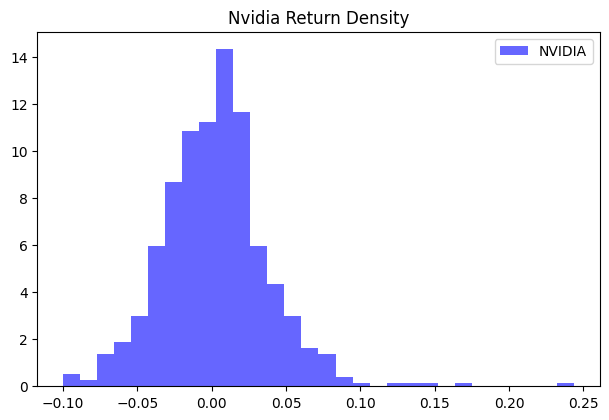

In [ ]:
# 2) Анализ временного ряда, анализ распределения  и проведения теста на стационарность
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.hist(nvda_returns, bins=30, density=True, alpha=0.6, color='b', label='NVIDIA')
plt.title('Nvidia Return Density')

plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
adf_test = adfuller(nvda_returns)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -25.565182
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [ ]:
if result[1] < 0.05:
    print("Временной ряд стационарен (отвергаем нулевую гипотезу).")
else:
    print("Временной ряд не стационарен (не отвергаем нулевую гипотезу).")

Временной ряд стационарен (отвергаем нулевую гипотезу).


In [ ]:
# 3) Выбор параметров для построения модели Arima
auto_arima_model = auto_arima(nvda_returns, seasonal=False, stepwise=False, suppress_warnings=True)
arima_order = auto_arima_model.order
print(f"Выбранный порядок модели ARIMA: {arima_order}")
print('при разных значениях параметров seasonal и stepwise результаты идентичны')

Выбранный порядок модели ARIMA: (0, 0, 0)
при разных значениях параметров seasonal и stepwise результаты идентичны


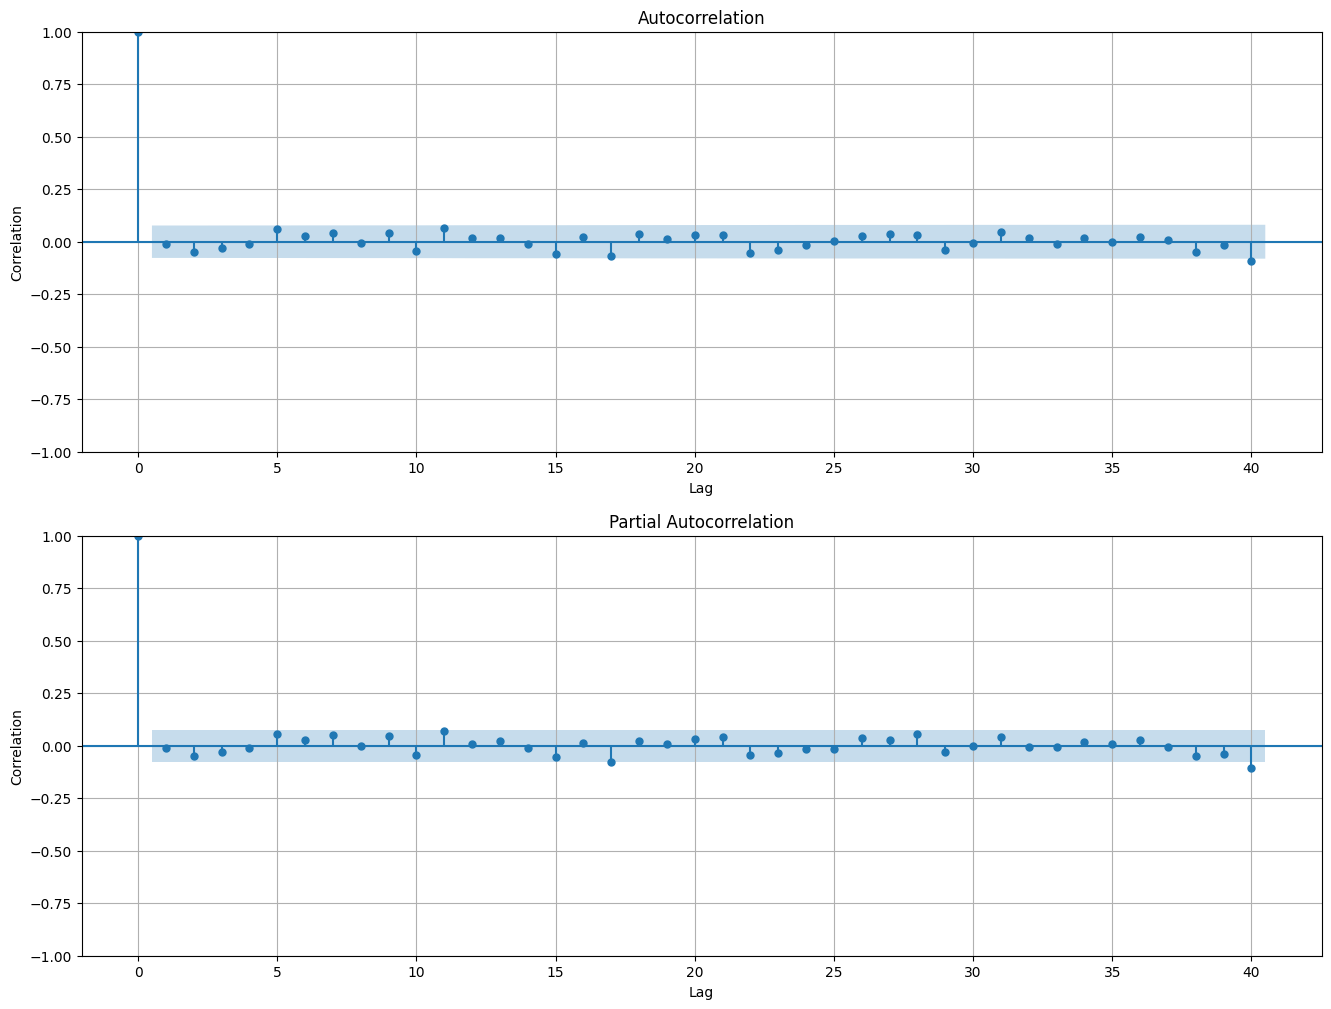

In [ ]:
# Для оценки параметров p q построим acf и pacf
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
plot_acf(nvda_returns, ax=axes[0], lags=40)
plot_pacf(nvda_returns, ax=axes[1], lags=40)
for ax in axes:
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation')
    ax.grid(True)
plt.show()

In [ ]:
# По итогу значения p и q выбрано 0 и 0
arima_order = (0, 0, 0)
arima_model = sm.tsa.ARIMA(nvda_returns, order=arima_order)
arima_result = arima_model.fit()
print(arima_result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  644
Model:                          ARIMA   Log Likelihood                1238.229
Date:                Fri, 14 Jun 2024   AIC                          -2472.458
Time:                        22:39:14   BIC                          -2463.522
Sample:                             0   HQIC                         -2468.990
                                - 644                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      1.829      0.067      -0.000       0.006
sigma2         0.0013   4.18e-05     29.980      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.06   Jarque-

In [ ]:
# Построение модели Garch, используя остатки модели arima
arima_residuals = arima_result.resid
garch_model = arch_model(arima_residuals, vol='Garch', p=1, q=1)
garch_result = garch_model.fit()
print(garch_result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2547408.575749801
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1240.9573578885552
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1240.957360841808
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1240.96
Distribution:                  Normal   AIC:                          -2473.91
Method:            Maximum Likelihood   BIC:                          -2456.04
                                        No. Observations:                  644
Date:                Fri, Jun 14 2024   Df Residuals:                      643
Time:         

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001252. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


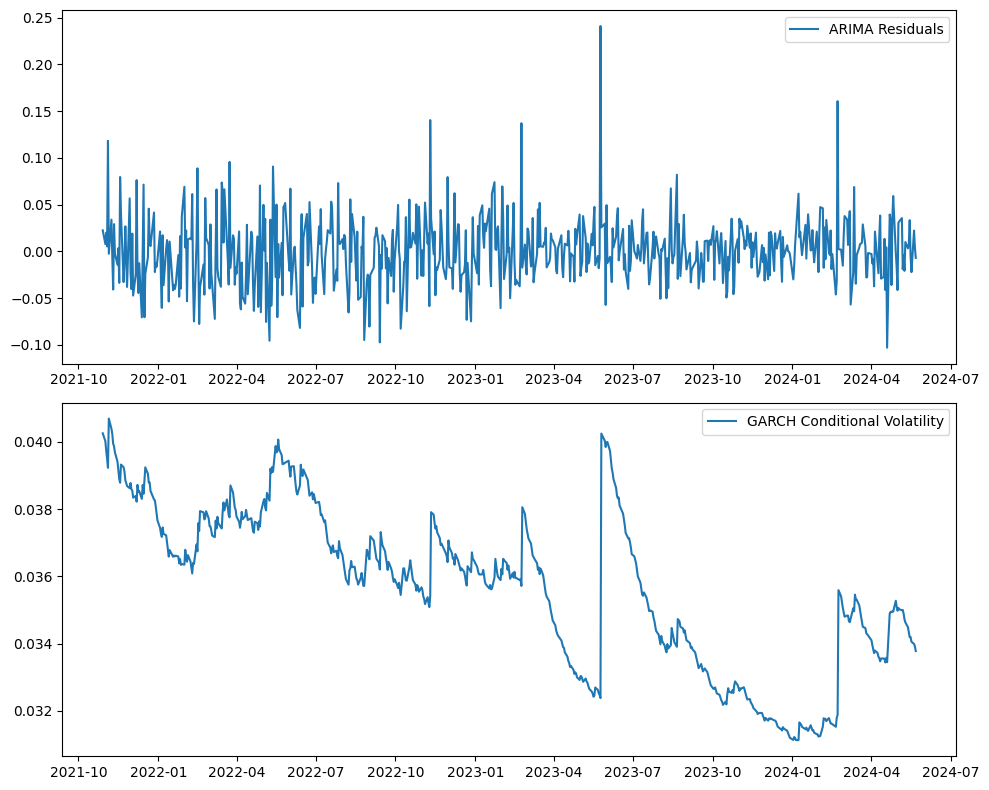

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(arima_residuals, label='ARIMA Residuals')
ax[0].legend()
ax[1].plot(garch_result.conditional_volatility, label='GARCH Conditional Volatility')
ax[1].legend()
plt.tight_layout()
plt.show()
print('В целом модель показывает хорошее соответсвие данным в плане описания условной волатильности, однако не имеет статистически значимой связи коэффицента среденего уровня')

In [ ]:
# Построение модели CAPM
X = sm.add_constant(market_returns)
y = nvda_returns
capm_model = sm.OLS(y, X).fit()
capm_summary = capm_model.summary()
print(capm_summary)

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     726.6
Date:                Fri, 14 Jun 2024   Prob (F-statistic):          1.28e-107
Time:                        21:56:12   Log-Likelihood:                 1482.0
No. Observations:                 644   AIC:                            -2960.
Df Residuals:                     642   BIC:                            -2951.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.137      0.0

In [ ]:
alpha = capm_model.params[0]
beta = capm_model.params[1]
alpha_p_value = capm_model.pvalues[0]
print(f"Рассчитанное значение α: {alpha:.4f} (p-value: {alpha_p_value:.4f})")
print(f"Рассчитанное значение β: {beta:.4f}")

Рассчитанное значение α: 0.0020 (p-value: 0.0330)
Рассчитанное значение β: 2.2545


In [ ]:
nvda_info = yf.Ticker(ticker).info
yahoo_beta = nvda_info['beta']
print(f"Значение β из Yahoo Finance: {yahoo_beta:.4f}")

Значение β из Yahoo Finance: 1.6940


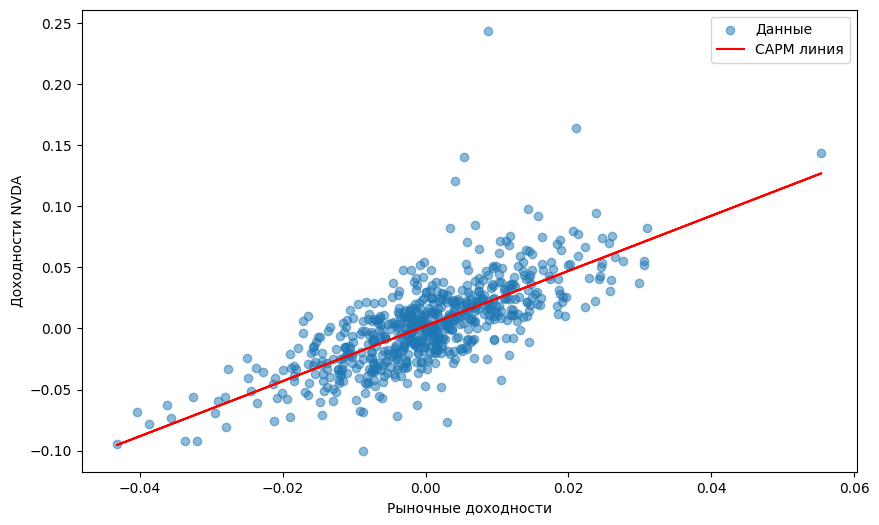

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(market_returns, nvda_returns, alpha=0.5, label='Данные')
plt.plot(market_returns, beta * market_returns + alpha, color='red', label='CAPM линия')
plt.xlabel('Рыночные доходности')
plt.ylabel('Доходности NVDA')
plt.legend()
plt.show()